<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
!pip install japanize-matplotlib | tail -n 1


## 1.訓練データ、学習データの準備 ################################
元データ： (506, 13) (506,)
項目名  ：  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']
絞込み後： (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]
## 2.計算用関数の準備 ############################################
入力次元数：1,出力次元数：1
## 3.繰り返し処理（予測、損失、最適化） ##########################
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


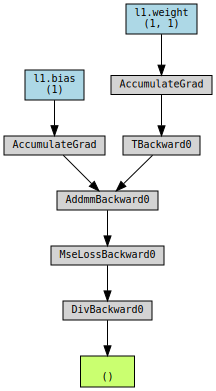

## before epoch:0 #################
weight.grad:tensor([[-99.8211]])	, bias.grad:tensor([-15.2482])
weight(bef):tensor([[1.]])	, bias     :tensor([1.])
weight(aft):tensor([[1.0998]])	, bias     :tensor([1.0152])
## before epoch:1000 #################
weight.grad:tensor([[-0.0674]])	, bias.grad:tensor([0.4283])
weight(bef):tensor([[3.5021]])	, bias     :tensor([0.9518])
weight(aft):tensor([[3.5022]])	, bias     :tensor([0.9514])
## before epoch:2000 #################
weight.grad:tensor([[-0.0666]])	, bias.grad:tensor([0.4232])
weight(bef):tensor([[3.5690]])	, bias     :tensor([0.5261])
weight(aft):tensor([[3.5691]])	, bias     :tensor([0.5256])
## before epoch:3000 #################
weight.grad:tensor([[-0.0657]])	, bias.grad:tensor([0.4181])
weight(bef):tensor([[3.6351]])	, bias     :tensor([0.1054])
weight(aft):tensor([[3.6352]])	, bias     :tensor([0.1050])
## before epoch:4000 #################
weight.grad:tensor([[-0.0650]])	, bias.grad:tensor([0.4131])
weight(bef):tensor([[3.7005]

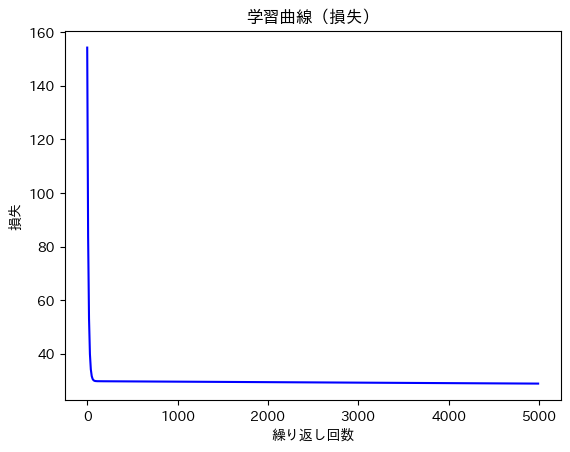

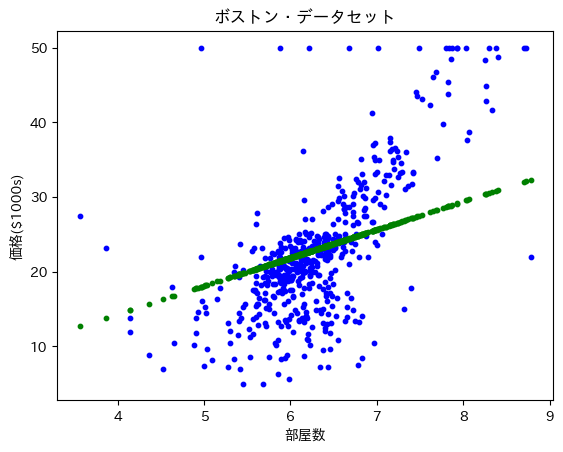

損失初期値：154.2249298095703
損失最終値：28.902339935302734


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torchinfo import summary
from torchviz import make_dot
pd.set_option('display.width', 160)
np.set_printoptions(linewidth=160)

# 学習用データ準備
# --- http://lib.stat.cmu.edu/datasets/boston ---
#  The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
#  prices and the demand for clean air', J. Environ. Economics & Management,
#  vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
#  ...', Wiley, 1980.   N.B. Various transformations are used in the table on
#  pages 244-261 of the latter.

#  Variables in order:
#  CRIM     per capita crime rate by town
#  ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#  INDUS    proportion of non-retail business acres per town
#  CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  NOX      nitric oxides concentration (parts per 10 million)
#  RM       average number of rooms per dwelling
#  AGE      proportion of owner-occupied units built prior to 1940
#  DIS      weighted distances to five Boston employment centres
#  RAD      index of accessibility to radial highways
#  TAX      full-value property-tax rate per $10,000
#  PTRATIO  pupil-teacher ratio by town
#  B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#  LSTAT    % lower status of the population
#  MEDV     Median value of owner-occupied homes in $1000's

#  0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30
#   396.90   4.98  24.00
#  0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80
#   396.90   9.14  21.60
# ↑折り返しがあるため、２種類のデータになってしまっている

print("## 1.訓練データ、学習データの準備 ################################")
data_url = "http://lib.stat.cmu.edu/datasets/boston"
# データ説明の22行をスキップし、空白で分割
raw_df = pd.read_csv(data_url, sep=r'\s+', skiprows=22, header=None)
# 奇数行（CRIM ～ PTRATIO）
bef_wrapping = raw_df.values[ ::2, :]
# 偶数行（B ～ LSTAT）
aft_wrapping = raw_df.values[1::2, :2]
# 水平結合して１つのデータにする（CRIM ～ LSTAT）
x_org = np.hstack([bef_wrapping, aft_wrapping])
# MEDV
yt = raw_df.values[1::2, 2]
feature_names = np.array([
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
])

# 結果確認
print('元データ：', x_org.shape, yt.shape)
print('項目名  ： ', feature_names)

# データの絞込み（項目RMのみ）
x = x_org[:, feature_names == 'RM']
print('絞込み後：', x.shape)
print(x[:5, :])

# 正解データyの表示
print('正解データ')
print(yt[:5])

print("## 2.計算用関数の準備 ############################################")
# 変数定義

lr = 0.001  # 学習率
num_epochs      = 5000 # 繰り返し回数
num_epochs_out  = 1000 # 履歴採取タイミング

# 入力次元数
n_input = x.shape[1]
# 出力次元数
n_output = 1
print(f"入力次元数：{n_input},出力次元数：{n_output}")

# カスタムクラス
class Net(torch.nn.Module):
  # 初期化
  def __init__(self, n_input, n_output):
    super().__init__()
    # 線形関数を生成
    self.l1 = torch.nn.Linear(n_input, n_output)
    # 重み、バイアスの初期値を設定
    torch.nn.init.constant_(self.l1.weight, 1.0)
    torch.nn.init.constant_(self.l1.bias, 1.0)

  # 予測関数
  def forward(self, inputs):
    outputs = self.l1(inputs) # 線形回帰
    return outputs

# 入力データ
inputs = torch.tensor(x).float()

# 教師データ
labels = torch.tensor(yt).float().view(-1, 1)

# カスタムクラスのインスタンスを生成
net = Net(n_input, n_output)

# 最適化関数（勾配降下法）
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化
history = np.zeros((0, 2))

# 繰り返し計算メインループ
print("## 3.繰り返し処理（予測、損失、最適化） ##########################")
for epoch in range(num_epochs):

  # 予測計算
  outputs = net(inputs)

  # 損失関数
  criterion = torch.nn.MSELoss()

  # 誤差計算
  loss = criterion(outputs, labels) / 2.0

  if (epoch == 0):
    print(summary(net, (1,)))
    g = make_dot(loss, params=dict(net.named_parameters()))
    display(g)

  # 勾配計算
  loss.backward()

  # 最適化
  bOut = False
  if epoch % num_epochs_out == 0:
    bOut = True
  if bOut:
    print(f'## before epoch:{epoch} #################')
    print(f'weight.grad:{net.l1.weight.grad}\t, bias.grad:{net.l1.bias.grad}')
    print(f'weight(bef):{net.l1.weight.data}\t, bias     :{net.l1.bias.data}')
  optimizer.step()
  if bOut:
    print(f'weight(aft):{net.l1.weight.data}\t, bias     :{net.l1.bias.data}')
  optimizer.zero_grad()

  if (epoch % 10 == 0):
    item = np.array([epoch, loss.item()])
    history = np.vstack((history, item))

print("## 4.結果表示 ####################################################")
# 学習曲線の表示（損失）
plt.plot(history[:, 0], history[:, 1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.show()

# 予測データを表示
plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格($1000s)')
plt.scatter(inputs.data, outputs.data, s=10, c='g')
plt.title('ボストン・データセット')
plt.show()

# 損失の初期値と最終値を表示
print(f"損失初期値：{history[ 0, 1]}")
print(f"損失最終値：{history[-1, 1]}")
